# Method 1 : Graph-Based Neural Network for Deception Detection in Diplomacy

This implementation processes conversations from the Diplomacy dataset (in JSONL format) into graph data using PyTorch Geometric. In each conversation, players (extracted from the "players" field) and messages (non-empty utterances) are modeled as nodes.
Edges are defined from a player (the speaker) to a message and from a message to a player
(the receiver). Each message node’s feature vector consists of:
  - A DistilBERT text embedding (derived from a frozen DistilBERT model’s [CLS]-like embedding).
  - One-hot encodings for the season and year.
  - A normalized game_score_delta (power imbalance), normalized by a maximum value (18).

We then build a Graph Neural Network (using HeteroConv with SAGEConv layers) to propagate
information and classify whether the final message is deceptive (derived from the sender’s label)
and whether it was perceived as deceptive (receiver’s label).

The overall functioning can be viewed in the flowchart below :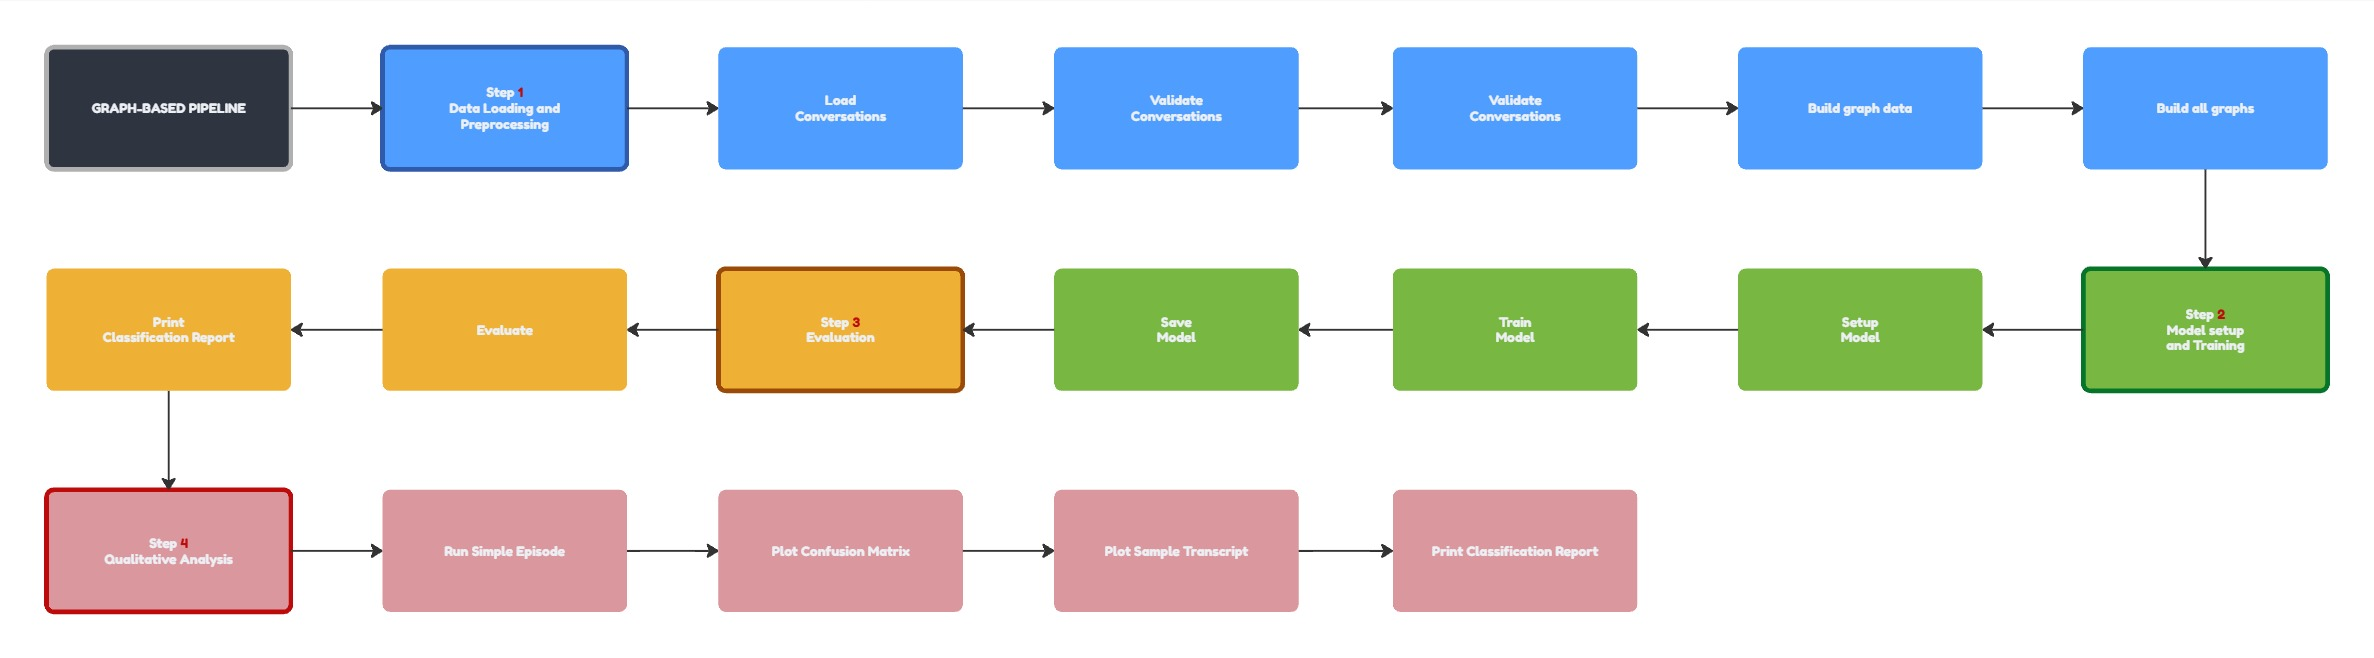

## Installing Dependicies

In [ ]:
pip install torch torchvision torch-geometric transformers scikit-learn matplotlib seaborn

In [2]:
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer, DistilBertModel, DistilBertTokenizer
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

## Global Definitions
Here we have defined the global variables including DistilBERT, Player and Time Mappings which will be used throughout the code

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
bert_model.to(device)
bert_model.eval()

def encode_message(text):
    """
    Encode a message text using DistilBERT.
    Returns the [CLS]-like embedding (first token) as a tensor on CPU.
    """
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze(0).cpu()

def load_conversations(filepath):
    convs = []
    with open(filepath, "r", encoding="utf8") as f:
        for line in f:
            convs.append(json.loads(line))
    return convs

train_convs = load_conversations('/content/train.jsonl')
val_convs   = load_conversations('/content/validation.jsonl')
test_convs  = load_conversations('/content/test.jsonl')

player_names = set()
for conv in (train_convs + val_convs + test_convs):
    for p in conv.get("players", []):
        player_names.add(p.lower())
player_names = sorted(list(player_names))
player_to_idx = {name: idx for idx, name in enumerate(player_names)}

all_years = set()
all_seasons = set()
for conv in (train_convs + val_convs + test_convs):
    for y in conv.get("years", []):
        all_years.add(int(y))
    for s in conv.get("seasons", []):
        all_seasons.add(s)
year_list = sorted(list(all_years))
season_list = sorted(list(all_seasons))
year_to_idx = {year: i for i, year in enumerate(year_list)}
season_to_idx = {season: i for i, season in enumerate(season_list)}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Preprocessing:
This implements the GraphPreprocessor loads and validates conversations from JSONL files, and builds heterogenous graph data from each conversation.Subfunctions:
- load_conversations: Loads JSONL file into conversation dicts.
- validate_conversation: Checks that required fields exist.
- build_graph_data: Converts a conversation into a PyTorch Geometric HeteroData object.
- build_all_graphs: Processes a list of conversations into graph objects (skipping invalid ones).

In [5]:
class GraphPreprocessor:
    REQUIRED_FIELDS = ["messages", "sender_labels", "game_score_delta"]

    @staticmethod
    def load_conversations(filepath):
        convs = []
        with open(filepath, "r", encoding="utf8") as f:
            for line in f:
                try:
                    conv = json.loads(line)
                    convs.append(conv)
                except Exception as e:
                    print(f"Error parsing {filepath}: {e}")
        return convs

    @staticmethod
    def validate_conversation(conv):
        for field in GraphPreprocessor.REQUIRED_FIELDS:
            if field not in conv or not conv.get(field):
                return False
        if len(conv["messages"]) == 0 or len(conv["sender_labels"]) == 0:
            return False
        return True

    @staticmethod
    def build_graph_data(conv):
        data = HeteroData()
        players = [p.lower() for p in conv.get("players", [])]
        if len(players) != 2:
            return None
        p_idx_map = {players[i]: i for i in range(len(players))}
        num_players = len(players)
        data['player'].num_nodes = num_players
        player_country_ids = [player_to_idx.get(name, 0) for name in players]
        data['player'].country_id = torch.tensor(player_country_ids, dtype=torch.long)

        messages = conv.get("messages", [])
        speakers = [s.lower() for s in conv.get("speakers", [])]
        receivers = [r.lower() for r in conv.get("receivers", [])]
        seasons = conv.get("seasons", [])
        years = conv.get("years", [])
        diffs = conv.get("game_score_delta", [])
        sender_labels = conv.get("sender_labels", [])
        receiver_labels = conv.get("receiver_labels", [])

        num_messages = len(messages)
        valid_indices = [i for i in range(num_messages) if messages[i].strip()]
        if len(valid_indices) == 0:
            return None

        messages = [messages[i] for i in valid_indices]
        speakers = [speakers[i] for i in valid_indices]
        receivers = [receivers[i] for i in valid_indices]
        seasons = [seasons[i] for i in valid_indices]
        years = [years[i] for i in valid_indices]
        diffs = [diffs[i] for i in valid_indices]
        sender_labels = [sender_labels[i] for i in valid_indices]
        receiver_labels = [receiver_labels[i] for i in valid_indices]
        num_messages = len(messages)

        message_feats = []
        sent_edge_index = [[], []]
        received_edge_index = [[], []]
        to_speaker_edge_index = [[], []]
        to_receiver_edge_index = [[], []]
        sender_y = []
        receiver_y = []

        for i in range(num_messages):
            text = messages[i]
            text_emb = encode_message(text)
            season_onehot = torch.zeros(len(season_list))
            if seasons[i] in season_to_idx:
                season_onehot[season_to_idx[seasons[i]]] = 1.0
            year_onehot = torch.zeros(len(year_list))
            try:
                year_int = int(years[i])
            except:
                year_int = year_list[0]
            if year_int in year_to_idx:
                year_onehot[year_to_idx[year_int]] = 1.0
            diff = float(diffs[i])
            diff_norm = diff / 18.0
            diff_tensor = torch.tensor([diff_norm])
            feat = torch.cat([text_emb, season_onehot, year_onehot, diff_tensor], dim=0)
            message_feats.append(feat)
            spk = speakers[i]
            recv = receivers[i]
            u = p_idx_map.get(spk, 0)
            v = p_idx_map.get(recv, 0)
            sent_edge_index[0].append(u)
            sent_edge_index[1].append(i)
            received_edge_index[0].append(v)
            received_edge_index[1].append(i)
            to_speaker_edge_index[0].append(i)
            to_speaker_edge_index[1].append(u)
            to_receiver_edge_index[0].append(i)
            to_receiver_edge_index[1].append(v)
            sender_y.append(0 if str(sender_labels[i]).lower() == "true" else 1)
            receiver_y.append(0 if str(receiver_labels[i]).lower() == "true" else 1)

        try:
            data['message'].x = torch.stack(message_feats, dim=0)
        except Exception as e:
            print("Error in stacking features:", e)
            return None
        data['message'].num_nodes = num_messages
        data['player', 'sent', 'message'].edge_index = torch.tensor(sent_edge_index, dtype=torch.long)
        data['player', 'received', 'message'].edge_index = torch.tensor(received_edge_index, dtype=torch.long)
        data['message', 'to_speaker', 'player'].edge_index = torch.tensor(to_speaker_edge_index, dtype=torch.long)
        data['message', 'to_receiver', 'player'].edge_index = torch.tensor(to_receiver_edge_index, dtype=torch.long)
        data['message'].sender_y = torch.tensor(sender_y, dtype=torch.long)
        data['message'].receiver_y = torch.tensor(receiver_y, dtype=torch.long)
        return data

    @staticmethod
    def build_all_graphs(conversations):
        graphs = []
        for conv in conversations:
            if GraphPreprocessor.validate_conversation(conv):
                g = GraphPreprocessor.build_graph_data(conv)
                if g is not None:
                    graphs.append(g)
        return graphs

train_graphs = GraphPreprocessor.build_all_graphs(train_convs)
val_graphs = GraphPreprocessor.build_all_graphs(val_convs)
test_graphs = GraphPreprocessor.build_all_graphs(test_convs)
print(f"Built graph data for {len(train_graphs)} training conversations.")


Built graph data for 184 training conversations.


## Training :
This Sets up and trains the Graph Neural Network for deception detection. Subfunctions:
- create_environment: (Not needed here; training on graphs directly.)
- setup_model: Instantiates the GNN classifier.
- train_model: Runs the training loop over the graph data.
- save_model: Saves the trained model to disk.

In [6]:
class GraphTrainer:
    def __init__(self, train_graphs, num_countries, hidden_dim=128):
        self.train_graphs = train_graphs
        self.num_countries = num_countries
        self.hidden_dim = hidden_dim
        self.model = None

    def setup_model(self):
        self.model = DiplomacyGNNClassifier(self.num_countries, self.hidden_dim).to(device)
        return self.model

    def train_model(self, epochs=50, lr=0.001):
        if self.model is None:
            self.setup_model()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        for epoch in range(1, epochs+1):
            self.model.train()
            total_loss = 0.0
            random.shuffle(self.train_graphs)
            for data in self.train_graphs:
                optimizer.zero_grad()
                sender_logits, receiver_logits = self.model(data)
                sender_labels = data['message'].sender_y.to(device)
                receiver_labels = data['message'].receiver_y.to(device)
                loss_sender = F.cross_entropy(sender_logits, sender_labels)
                loss_receiver = F.cross_entropy(receiver_logits, receiver_labels)
                loss = loss_sender + loss_receiver
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(self.train_graphs)
            print(f"Epoch {epoch}/{epochs}, Training loss: {avg_loss:.4f}")
        return self.model

    def save_model(self, filepath):
        if self.model is not None:
            torch.save(self.model.state_dict(), filepath)
            print(f"Model saved to {filepath}")
        else:
            print("Model not trained yet; nothing to save.")

## Evaluation
Evaluates the trained GNN model on test graph data. Subfunctions:
- evaluate: Runs the model on test graphs, aggregating true and predicted labels.
- print_classification_report: Prints accuracy, macro F1, and Lie F1, plus detailed report.

In [7]:
class GraphEvaluator:
    def __init__(self, model, test_graphs):
        self.model = model
        self.test_graphs = test_graphs

    def evaluate(self):
        self.model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for data in self.test_graphs:
                sender_logits, _ = self.model(data)
                preds = sender_logits.argmax(dim=1).cpu().numpy()
                true_labels = data['message'].sender_y.numpy()
                y_true.extend(true_labels)
                y_pred.extend(preds)
        return y_true, y_pred

    def print_classification_report(self):
        y_true, y_pred = self.evaluate()
        acc = accuracy_score(y_true, y_pred)
        macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        if 0 in set(y_true) and 1 in set(y_true):
            lie_f1 = f1_score(y_true, y_pred, pos_label=0)
        else:
            lie_f1 = f1_score(y_true, y_pred, pos_label=1)
        print(f"Test Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}, Lie F1: {lie_f1:.4f}\n")

##  Graph Neural Network Classifier :
Graph Neural Network classifier that uses heterogenous message and player nodes.
    
- Nodes:
   - player: Contains the player's identity (via a country embedding).
   - message: Contains precomputed features (DistilBERT embedding, one-hot season, one-hot year, normalized diff).
    
- Edges:
   - 'player' -> 'message': From speaker to message.
   - 'player' -> 'message': From receiver to message.
   - 'message' -> 'player': Reverse edges.
    
- Two linear classification heads are used:
   - deception_head: Predicts the sender's deception (Truth vs. Lie).
   - perception_head: Predicts the receiver's perception (not used for training here but for analysis).

In [8]:
class DiplomacyGNNClassifier(nn.Module):
    def __init__(self, num_countries, hidden_dim):
        super(DiplomacyGNNClassifier, self).__init__()
        self.player_emb = nn.Embedding(num_countries, hidden_dim)
        self.conv1 = HeteroConv({
            ('player', 'sent', 'message'): SAGEConv((-1, -1), hidden_dim),
            ('player', 'received', 'message'): SAGEConv((-1, -1), hidden_dim),
            ('message', 'to_speaker', 'player'): SAGEConv((-1, -1), hidden_dim),
            ('message', 'to_receiver', 'player'): SAGEConv((-1, -1), hidden_dim)
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('player', 'sent', 'message'): SAGEConv((-1, -1), hidden_dim),
            ('player', 'received', 'message'): SAGEConv((-1, -1), hidden_dim),
            ('message', 'to_speaker', 'player'): SAGEConv((-1, -1), hidden_dim),
            ('message', 'to_receiver', 'player'): SAGEConv((-1, -1), hidden_dim)
        }, aggr='sum')
        self.deception_head = nn.Linear(hidden_dim, 2)
        self.perception_head = nn.Linear(hidden_dim, 2)

    def forward(self, data):
        x_dict = {}
        country_ids = data['player'].country_id.to(device)
        x_dict['player'] = self.player_emb(country_ids)
        x_dict['message'] = data['message'].x.to(device)
        edge_index_dict = {}
        for rel in data.edge_index_dict:
            edge_index_dict[rel] = data.edge_index_dict[rel].to(device)
        out_dict1 = self.conv1(x_dict, edge_index_dict)
        out_dict1 = {k: F.relu(v) for k, v in out_dict1.items()}
        out_dict2 = self.conv2(out_dict1, edge_index_dict)
        out_dict2 = {k: F.relu(v) for k, v in out_dict2.items()}
        message_repr = out_dict2['message']
        sender_logits = self.deception_head(message_repr)
        receiver_logits = self.perception_head(message_repr)
        return sender_logits, receiver_logits

## Qualitative Analysis :
Provides tools for qualitative analysis of the graph-based deception detection model. Methods:
      - run_sample_episode: Run the model on one test graph and return details.
      - plot_confusion_matrix: Compute and plot the confusion matrix on the test set.
      - plot_sample_transcript: Print a transcript for one conversation, including features and predictions.

In [9]:
class GraphQualitativeAnalyzer:
    def __init__(self, model, test_graphs):
        self.model = model
        self.test_graphs = test_graphs

    def run_sample_episode(self):
        data = random.choice(self.test_graphs)
        self.model.eval()
        with torch.no_grad():
            sender_logits, _ = self.model(data)
        pred = sender_logits.argmax(dim=1).cpu().numpy()
        true = data['message'].sender_y.cpu().numpy()
        transcript = {
            "num_messages": data['message'].num_nodes,
            "true_labels": true.tolist(),
            "predictions": pred.tolist()
        }
        return transcript

    def plot_confusion_matrix(self):
        all_true = []
        all_preds = []
        self.model.eval()
        with torch.no_grad():
            for data in self.test_graphs:
                sender_logits, _ = self.model(data)
                pred = sender_logits.argmax(dim=1).cpu().numpy()
                true = data['message'].sender_y.cpu().numpy()
                all_true.extend(true.tolist())
                all_preds.extend(pred.tolist())
        cm = confusion_matrix(all_true, all_preds)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Truth", "Lie"], yticklabels=["Truth", "Lie"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix - Graph-Based Model")
        plt.show()

    def plot_sample_transcript(self):
        transcript = self.run_sample_episode()
        print("Sample Transcript from a Test Conversation (Graph-Based):")
        num_msgs = transcript["num_messages"]
        true_labels = transcript["true_labels"]
        preds = transcript["predictions"]
        for i in range(num_msgs):
            print(f"Message {i+1:3d}: True Label = {true_labels[i]}, Prediction = {preds[i]}")
        print("----------------------------------------------------")

## Main call

In [19]:
print("Setting up training for the Graph-Based Neural Network...")
print(f"Graph data built for {len(train_graphs)} training conversations.")

hidden_dim = 128
num_countries = len(player_to_idx)
trainer = GraphTrainer(train_graphs, num_countries, hidden_dim=hidden_dim)
trainer.setup_model()
trainer.train_model(epochs=50, lr=0.001)
trainer.save_model("graph_deception_model.pth")

Setting up training for the Graph-Based Neural Network...
Graph data built for 184 training conversations.
Epoch 1/50, Training loss: 0.8065
Epoch 2/50, Training loss: 0.7388
Epoch 3/50, Training loss: 0.7199
Epoch 4/50, Training loss: 0.7041
Epoch 5/50, Training loss: 0.6829
Epoch 6/50, Training loss: 0.6723
Epoch 7/50, Training loss: 0.6622
Epoch 8/50, Training loss: 0.6408
Epoch 9/50, Training loss: 0.6364
Epoch 10/50, Training loss: 0.6157
Epoch 11/50, Training loss: 0.6015
Epoch 12/50, Training loss: 0.6100
Epoch 13/50, Training loss: 0.6056
Epoch 14/50, Training loss: 0.5736
Epoch 15/50, Training loss: 0.5701
Epoch 16/50, Training loss: 0.5796
Epoch 17/50, Training loss: 0.5749
Epoch 18/50, Training loss: 0.5541
Epoch 19/50, Training loss: 0.5383
Epoch 20/50, Training loss: 0.5227
Epoch 21/50, Training loss: 0.5147
Epoch 22/50, Training loss: 0.5007
Epoch 23/50, Training loss: 0.4905
Epoch 24/50, Training loss: 0.4927
Epoch 25/50, Training loss: 0.4759
Epoch 26/50, Training loss:

In [20]:
evaluator = GraphEvaluator(trainer.model, test_graphs)
evaluator.print_classification_report()

Test Accuracy: 0.9055, Macro F1: 0.5076, Lie F1: 0.9502



In [21]:
analyzer = GraphQualitativeAnalyzer(trainer.model, test_graphs)

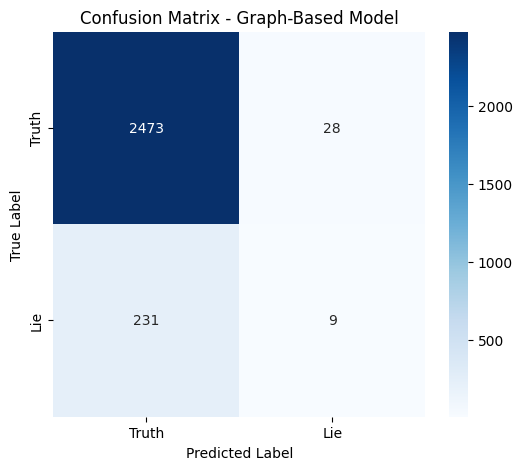

In [22]:
analyzer.plot_confusion_matrix()

In [24]:
analyzer.plot_sample_transcript()

Sample Transcript from a Test Conversation (Graph-Based):
Message   1: True Label = 0, Prediction = 0
Message   2: True Label = 0, Prediction = 0
Message   3: True Label = 0, Prediction = 0
Message   4: True Label = 0, Prediction = 0
Message   5: True Label = 0, Prediction = 0
Message   6: True Label = 0, Prediction = 0
Message   7: True Label = 0, Prediction = 0
Message   8: True Label = 0, Prediction = 0
Message   9: True Label = 0, Prediction = 0
Message  10: True Label = 0, Prediction = 0
Message  11: True Label = 1, Prediction = 0
Message  12: True Label = 0, Prediction = 0
Message  13: True Label = 0, Prediction = 0
Message  14: True Label = 0, Prediction = 0
Message  15: True Label = 0, Prediction = 0
Message  16: True Label = 1, Prediction = 0
Message  17: True Label = 0, Prediction = 0
Message  18: True Label = 0, Prediction = 0
Message  19: True Label = 0, Prediction = 0
Message  20: True Label = 0, Prediction = 0
Message  21: True Label = 0, Prediction = 0
Message  22: True 